# Machine Learning Engineer Nanodegree

## Facial emotion recognition

---

## Step 0: Prepare image repository

### Generate images from pixels

We begin with generating images from pixel dataset and storing them in their respective folders according thier emotion class and category (Train, PrivateTest, PublicTest). 
The library `PIL` is used to convert pixels to images. 
- `fer2013.csv` - base dataset hosted by the Kaggle competition

Each row represents a face. There are 3 columns:
- `emotions` - emotion expressed by the face
- `pixels` - this column contains 2304 pixel values in space-separated manner
- `category` - purpose of the image (Train, PrivateTest, PublicTest)


In [1]:
import numpy as np
import scipy.misc as smp
import csv
from PIL import Image
count = 1
strEmotion = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']


In [6]:
import keras

ImportError: No module named 'keras'

In [ ]:
with open('fer/fer2013.csv', 'rt') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        x = row[1].split()
        x1=np.reshape(x,(48,48))
        img = Image.new( 'RGB', (48,48), "black") 
        pixels = img.load() # create the pixel map
        for i in range(img.size[0]):    # for every col:
            for j in range(img.size[1]):    # For every row
                pixels[i,j] = (int(x1[j][i]), 0, 0) 

        img.save('fer/'+row[2]+'/'+row[0]+'_'+strEmotion[int(row[0])]+'/'+row[0] +'_'+str(count)+'.jpg')
        count += 1


## Step 1: Import image data

### Read images as 4D tensors


In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    emo_files = np.array(data['filenames'])
    emo_targets = np_utils.to_categorical(np.array(data['target']), 7)
    return emo_files, emo_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('fer/Training')
valid_files, valid_targets = load_dataset('fer/PrivateTest')
test_files, test_targets = load_dataset('fer/PublicTest')

# load list of emotions
emo_names = [item[13:-1] for item in sorted(glob("fer/Training/*/"))]

# print statistics about the dataset
print('There are %d total emotion categories.' % len(emo_names))
print('There are %s total facial images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training facial images.' % len(train_files))
print('There are %d validation facial images.' % len(valid_files))
print('There are %d test facial images.'% len(test_files))

ImportError: No module named 'keras'

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path,grayscale=True, target_size=(48, 48))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---
<a id='step3'></a>
## Step 2: Rescale the image 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████| 3589/3589 [00:01<00:00, 1968.73it/s]


## Step 3: Model Architecture

The code cell below defines the model architecture: 

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.initializers import TruncatedNormal,glorot_normal
import math

model = Sequential()

n = 0.01
model.add(Conv2D(filters=4, kernel_size=4, strides=1, padding='same', activation='relu',input_shape=(48, 48, 1)
                 ,kernel_initializer=glorot_normal(seed=0)
                 ,bias_initializer='zeros',name = "Input"))

model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=2, strides=2))

n = 0.01
model.add(Conv2D(filters=8, kernel_size=6, strides=1, padding='same', activation='relu'
                 ,kernel_initializer=glorot_normal(seed=0)
                 ,bias_initializer='zeros'))

model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=16, kernel_size=8, strides=1, padding='same', activation='relu'
                 ,kernel_initializer=glorot_normal(seed=0)
                 ,bias_initializer='zeros'))

model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())

model.add(Dense(25,activation = 'relu'))
model.add(Dense(15,activation = 'relu'))
#n = math.sqrt(2.0/(9*256))
model.add(Dense(7,activation='softmax',name="Output"))

model.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Conv2D)               (None, 48, 48, 4)         68        
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
con

### Compile the Model

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Train the Model

In [7]:
from keras.callbacks import ModelCheckpoint,CSVLogger

epochs = 100
csv_logger = CSVLogger('logs/training.csv')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=70, callbacks=[checkpointer,csv_logger], verbose=0)

Epoch 00000: val_loss improved from inf to 1.80231, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00001: val_loss improved from 1.80231 to 1.77558, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00002: val_loss improved from 1.77558 to 1.71352, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 1.71352 to 1.68931, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00004: val_loss improved from 1.68931 to 1.64174, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00005: val_loss improved from 1.64174 to 1.59286, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 1.59286 to 1.57016, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 1.57

### Load the Model with the Best Validation Loss

In [8]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

## Step 4: Test the Model

In [9]:
emotion_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(emotion_predictions)==np.argmax(test_targets, axis=1))/len(emotion_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.3422%


## Step 5: Model prediction

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline
strEmotion = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
def get_emotion(img_path):
    emotion_class = model.predict_classes(path_to_tensor(img_path))
    return emotion_class

In [11]:
def emotion_detector(img_path):
    emotion = get_emotion(img_path) 
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    print("Emotion detected: " + str(strEmotion[emotion]))
    

1/1 [==============================] - 0s


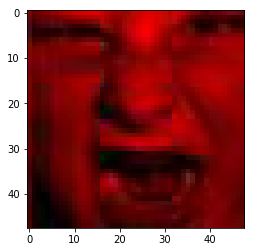

TypeError: only integer scalar arrays can be converted to a scalar index

In [12]:
test_imgs = np.array(glob("test_images/*"))
#print(test_imgs)
for img in test_imgs:
    emotion_detector(img)
    print("Actual emotion: " + str(strEmotion[int(img[12:13])]))


In [13]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from keras import backend as K

Instructions for updating:
Use the retry module or similar alternatives.


In [14]:
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out_kn', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out_kn/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out_kn/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out_kn/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out_kn/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out_kn/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out_kn/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")


In [19]:
MODEL_NAME = 'emoticon'
export_model(tf.train.Saver(), model, ["Input/truncated_normal"], "Output/Softmax")

INFO:tensorflow:Restoring parameters from out_kn/emoticon.chkp
INFO:tensorflow:Froze 12 variables.
Converted 12 variables to const ops.


KeyError: "The following input nodes were not found: {'Input/truncated_normal'}\n"